Ignore warning from torch and FastAI's issues

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Import Pytorch and check version

In [ ]:
import torch 
print(torch.__version__)

1.5.1+cu101


Since our dataset is on Google drive, we connect the drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Set path

In [ ]:
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + "Covid img/models"
parent_dir = root_dir + "Covid img/medium/covid_hackathon"

Import FastAI library

In [ ]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

Set batch size

In [ ]:
bs = 64  

Check if anything wrong with dataset in Gdrive

In [ ]:
path = Path('gdrive/My Drive/Covid img/medium/covid_hackathon')

In [ ]:
print(path)

gdrive/My Drive/Covid img/medium/covid_hackathon


In [ ]:
path.ls()

[PosixPath('gdrive/My Drive/Covid img/medium/covid_hackathon/train'),
 PosixPath('gdrive/My Drive/Covid img/medium/covid_hackathon/validation'),
 PosixPath('gdrive/My Drive/Covid img/medium/covid_hackathon/test'),
 PosixPath('gdrive/My Drive/Covid img/medium/covid_hackathon/models')]

torch.Size([3, 1800, 1750])


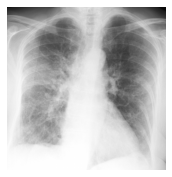

In [ ]:
img = open_image(path/'train/covid/covid117.jpeg')
print(img.data.shape)
img.show()

Set randomseed and transform images from model heatmap

In [ ]:
np.random.seed(7)
tfms = get_transforms(do_flip=True,flip_vert=False, max_rotate=25, max_lighting=0.5, max_zoom=1.5)

In [ ]:
data = ImageDataBunch.from_folder(path, train="train", valid='validation', test='test', ds_tfms=tfms, size=224, bs=bs,
                                  num_workers=4).normalize(imagenet_stats)

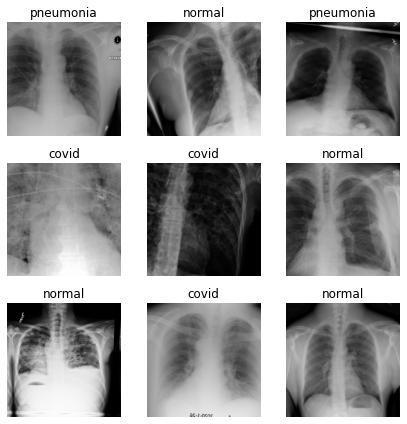

In [ ]:
data.show_batch(3, figsize=(6,6))

In [ ]:
data.c, len(data.train_ds), len(data.valid_ds), len(data.test_ds), len(data.classes)

(3, 680, 85, 124, 3)

Modeling

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy])

In [ ]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.591793,3.410673,0.482353,00:33
1,1.581346,1.577744,0.541176,00:32
2,1.450815,1.101520,0.647059,00:32
3,1.321660,0.954945,0.623529,00:32
4,1.201665,0.909295,0.635294,00:32


Check path for save model

In [ ]:
dest=Path(base_dir)
try:
  dest.mkdir(parents=True, exist_ok=False)
except FileExistsError:
  print ('File Already Exists')

File Already Exists


In [ ]:
learn.save(dest/'covidhack_stage-1')

Check how model performed

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

Model can't detect anything from images so we should try to optimise the model

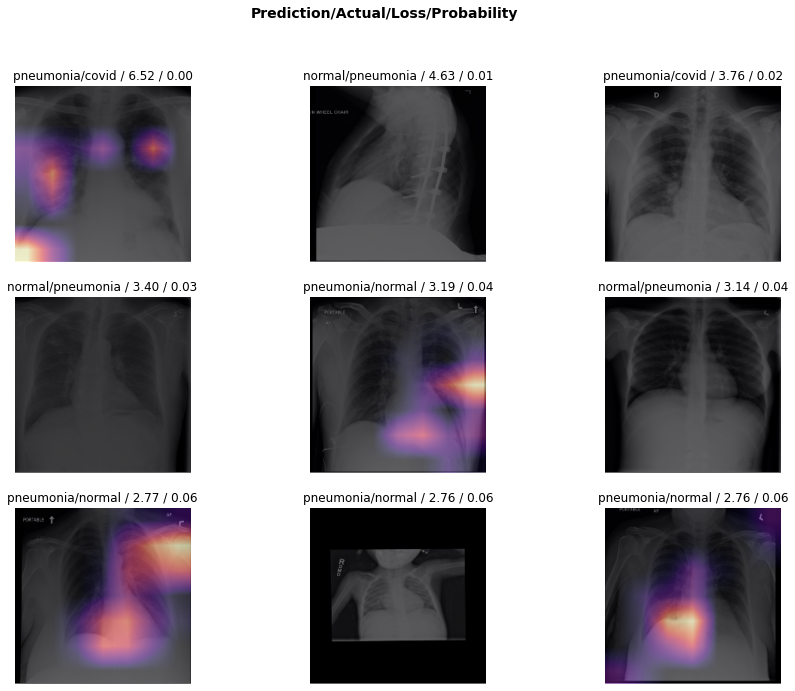

In [ ]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=True)

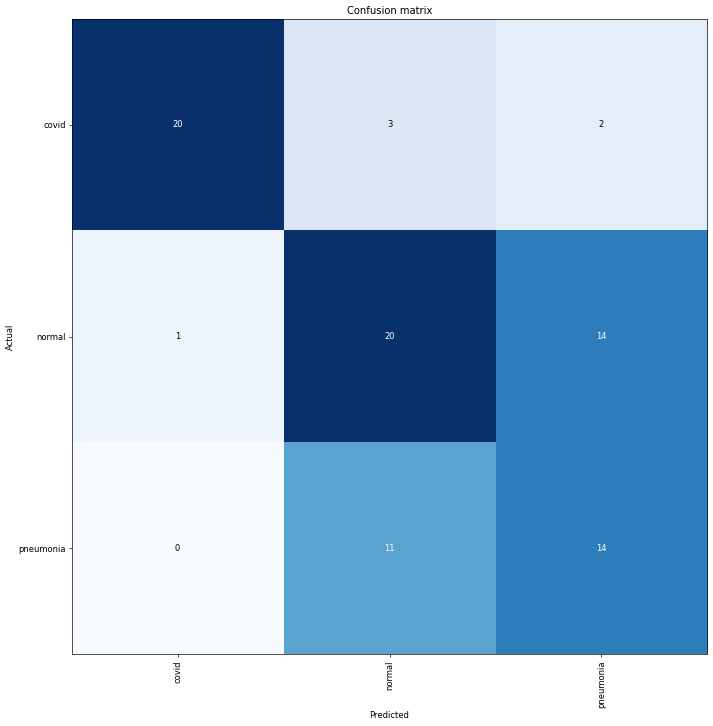

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

[('normal', 'pneumonia', 14),
 ('pneumonia', 'normal', 11),
 ('covid', 'normal', 3),
 ('covid', 'pneumonia', 2)]

Unfreezing, fine-tuning and learning rates

In [ ]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


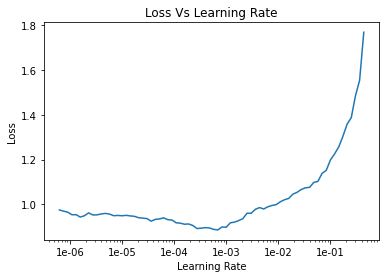

In [ ]:
learn.lr_find()
learn.recorder.plot()
plt.title("Loss Vs Learning Rate")
plt.show()

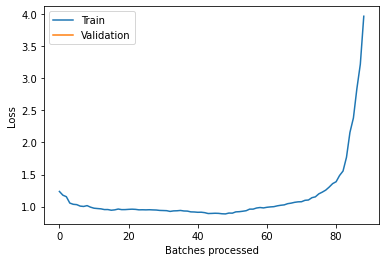

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-4, 1e-3)) #3e-5, 3e-4

epoch,train_loss,valid_loss,accuracy,time
0,0.921677,1.269492,0.552941,00:32
1,0.915326,2.806054,0.517647,00:33
2,0.903589,0.947642,0.623529,00:33
3,0.817929,0.848388,0.647059,00:33
4,0.751333,0.844487,0.647059,00:33


In [ ]:
learn.save(dest/'covidhack_stage-2')

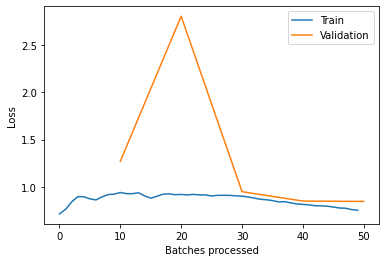

In [ ]:
learn.recorder.plot_losses()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

The model performed better but did worse in the last class that is Pneumonia 

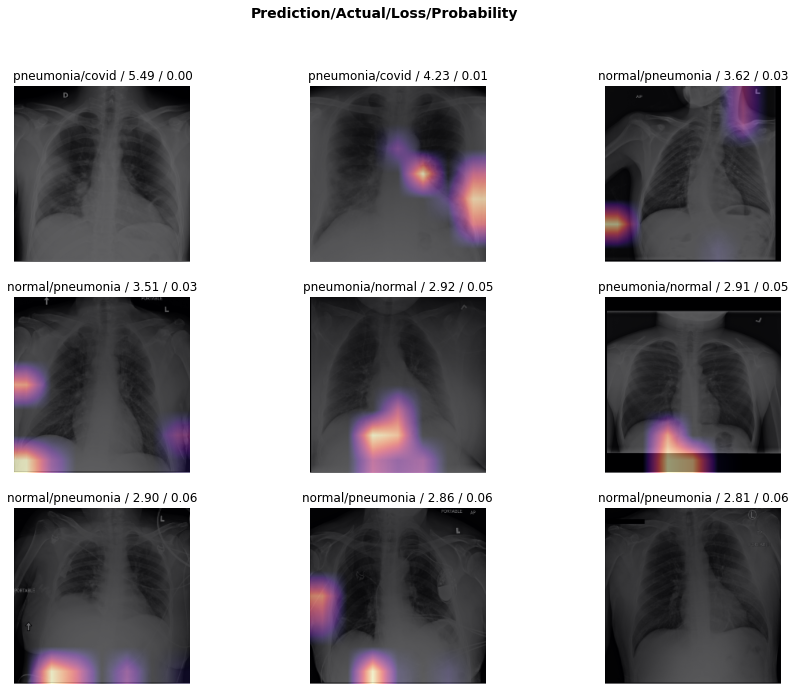

In [ ]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=True)

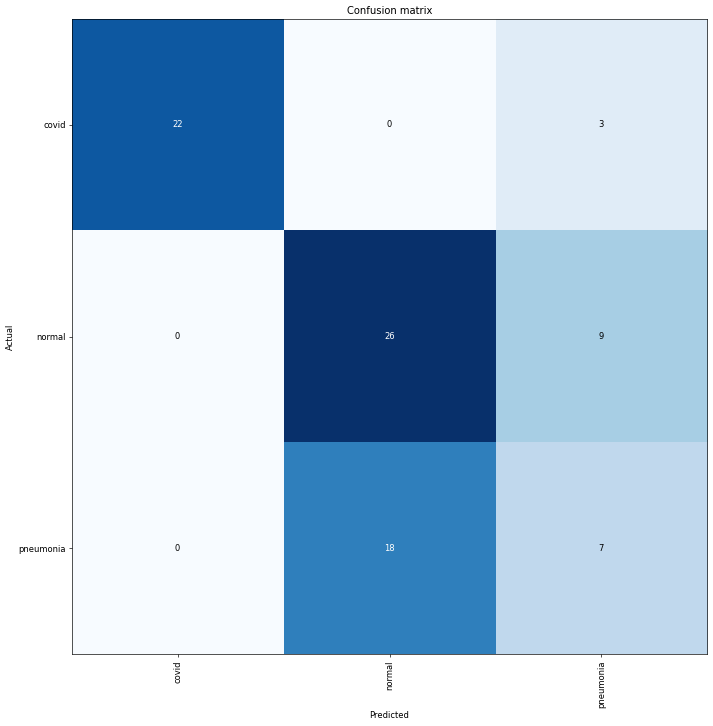

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

[('pneumonia', 'normal', 18),
 ('normal', 'pneumonia', 9),
 ('covid', 'pneumonia', 3)]

Test our model with data

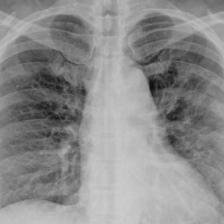

In [ ]:
img = learn.data.test_ds[0][0]
img

In [ ]:
pred = learn.predict(img)
print(str(pred[0]))


covid


In [ ]:
learn.data.classes

['covid', 'normal', 'pneumonia']